In [5]:
# Download the dataset
!kaggle datasets download -d noamsegal/affectnet-training-data

import zipfile

with zipfile.ZipFile("affectnet-training-data.zip", "r") as zip_ref:
    zip_ref.extractall("affectnet_data")

Dataset URL: https://www.kaggle.com/datasets/noamsegal/affectnet-training-data
License(s): Attribution-NonCommercial-ShareAlike 3.0 IGO (CC BY-NC-SA 3.0 IGO)
affectnet-training-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

In [7]:
#Mapping
class_mapping = {
    'neutral': 0,
    'happy': 1,
    'sad': 2,
    'surprise': 3,
    'fear': 4,
    'disgust': 5,
    'anger': 6,
    'contempt': 7
}
#Load images and labels
def load_images_and_labels(base_dir, class_mapping, target_size=(48, 48)):
    X = []
    y = []
    for class_name, class_idx in class_mapping.items():
        folder_path = os.path.join(base_dir, class_name)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                img = img / 255.0  # Normalization
                X.append(img)
                y.append(class_idx)
    return np.array(X), np.array(y)

# Dataset dir
base_dir = "affectnet_data/"

# Load data
X, y = load_images_and_labels(base_dir, class_mapping, target_size=(48, 48))

# Shapes
print("X Shape (images):", X.shape)
print("y Shape (labels):", y.shape)

X Shape (images): (29042, 48, 48, 3)
y Shape (labels): (29042,)


In [8]:
# Counting images per class
def count_images_per_class(base_dir, class_mapping):
    class_counts = {}
    for class_name, class_idx in class_mapping.items():
        folder_path = os.path.join(base_dir, class_name)
        num_images = len(os.listdir(folder_path))
        class_counts[class_name] = num_images
    return class_counts

class_counts = count_images_per_class(base_dir, class_mapping)

# Show the numbers
for class_name, count in class_counts.items():
    print(f"Class '{class_name}' have {count} images.")

Class 'neutral' have 5126 images.
Class 'happy' have 5044 images.
Class 'sad' have 3091 images.
Class 'surprise' have 4039 images.
Class 'fear' have 3176 images.
Class 'disgust' have 2477 images.
Class 'anger' have 3218 images.
Class 'contempt' have 2871 images.


In [9]:
# Spliting 80/20 train and test and 50/50 for val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Train data:", X_train.shape)
print("Validation data:", X_val.shape)
print("Test data:", X_test.shape)

Train data: (23233, 48, 48, 3)
Validation data: (2904, 48, 48, 3)
Test data: (2905, 48, 48, 3)


In [10]:
# I convert to one hot encoding because is better for DNN
num_classes = len(class_mapping)
y_train_onehot = to_categorical(y_train, num_classes)
y_val_onehot = to_categorical(y_val, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)


In [11]:
# Model creation
def create_dnn(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flat the images
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Creation
input_shape = (48, 48, 3)  # shape and 3 for rgb chanels
dnn_model = create_dnn(input_shape, num_classes)
dnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 6912)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,539,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,704,712 (14.13 MB)

 Trainable params: 3,704,712 (14.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#Training of DNN
history = dnn_model.fit(
    X_train, y_train_onehot,
    validation_data=(X_val, y_val_onehot),
    epochs=30,
    batch_size=64,
    verbose=1
)

Epoch 1/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.1690 - loss: 2.3904 - val_accuracy: 0.2624 - val_loss: 1.7296
Epoch 2/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.2154 - loss: 1.8988 - val_accuracy: 0.3185 - val_loss: 1.7059
Epoch 3/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.2153 - loss: 1.8947 - val_accuracy: 0.2972 - val_loss: 1.6876
Epoch 4/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.2129 - loss: 1.8826 - val_accuracy: 0.3223 - val_loss: 1.7062
Epoch 5/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 51s 92ms/step - accuracy: 0.2236 - loss: 1.8710 - val_accuracy: 0.3237 - val_loss: 1.7283
Epoch 6/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.2213 - loss: 1.8778 - val_accuracy: 0.2751 - val_loss: 1.7747
Epoch 7/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.2246 - loss: 1.8719 - val_accuracy: 0.2765 - val_loss: 1.7514
Epoch 8/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.2223 - loss: 1.8788 - 

In [13]:

test_loss, test_accuracy = dnn_model.evaluate(X_test, y_test_onehot)
print(f"Loss in test data: {test_loss:.4f}")
print(f"Accuaracy on test data: {test_accuracy:.4f}")

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3032 - loss: 1.6909
Loss in test data: 1.6913
Accuaracy on test data: 0.2947


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


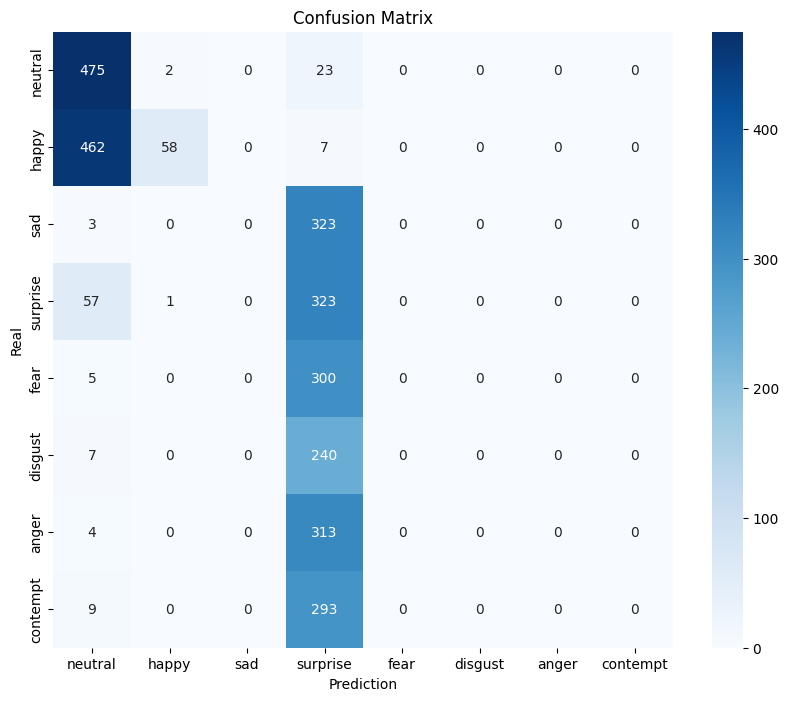


Clasification Report:

              precision    recall  f1-score   support

     neutral       0.46      0.95      0.62       500
       happy       0.95      0.11      0.20       527
         sad       0.00      0.00      0.00       326
    surprise       0.18      0.85      0.29       381
        fear       0.00      0.00      0.00       305
     disgust       0.00      0.00      0.00       247
       anger       0.00      0.00      0.00       317
    contempt       0.00      0.00      0.00       302

    accuracy                           0.29      2905
   macro avg       0.20      0.24      0.14      2905
weighted avg       0.28      0.29      0.18      2905



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_pred = dnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


conf_matrix = confusion_matrix(y_test, y_pred_classes)
labels = list(class_mapping.keys())


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.show()

print("\nClasification Report:\n")
classification_report_text = classification_report(y_test, y_pred_classes, target_names=labels)
print(classification_report_text)

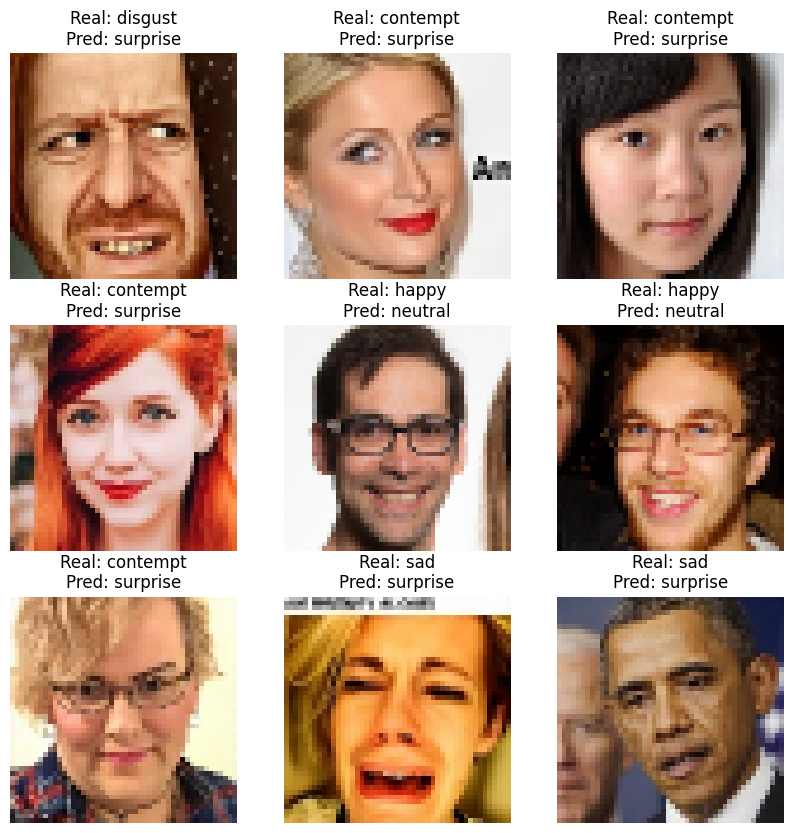

In [21]:
import matplotlib.pyplot as plt
import numpy as np


misclassified_indices = np.where(y_test != y_pred_classes)[0]


plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Real: {labels[y_test[idx]]}\nPred: {labels[y_pred_classes[idx]]}")
    plt.axis("off")
plt.show()